In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
from pandas import DataFrame as dframe
import cvxpy as cv

In [20]:
def Dic(feat_l_tr,feat_r_tr): #入力の配列は2次元配列である必要がある
    feat_tr = np.concatenate([feat_l_tr, feat_r_tr],0)
    return feat_tr

In [21]:
#各クラスの特徴ベクトルの配列の列数を格納した配列を引数にすればもう少し拡張性が上がる
def SRC(feat_tr_dic,feat_l_te,matrix_index):
    answer = np.zeros(feat_l_te.shape[1])
    SRC_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SRC_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SRC_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        x = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(cv.norm(x,1))
        constraints = [feat_l_te[:,i,np.newaxis] == feat_tr_dic@x]
        prob = cv.Problem(objective, constraints)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付ける
        SRC_Cla[:,i] = np.squeeze(x.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SRC_l_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SRC_r_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SRC_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SRC_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [22]:
def SRC_test(filename1,filename2,filename3,filename4):
    #対象被験者の特徴ベクトルをMATLABから入手
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #特徴ベクトルを2次元に変換
    #特徴ベクトル g は２M×Tになっている必要がある
    #Tは被験者の試行回数である
    feat_tr_dic = Dic(feat_C1,feat_C2).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #まず、分類に用いるテストデータの特徴ベクトルを2次元に変換
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T
    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0]])
    answer1 = SRC(feat_tr_dic,feat_l_te,matrix_index)
    answer2 = SRC(feat_tr_dic,feat_r_te,matrix_index)
    x1 = 0
    x2 = 0
    for i in range(answer1.shape[0]):
        if answer1[i] == 1:
            x1 = x1 + 1
        if answer2[i] == 2:
            x2 = x2 + 1
    temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
    temp1 = ((x1)/(answer1.shape[0]))*100
    temp2 = ((x2)/(answer2.shape[0]))*100
                    
    return temp,temp1,temp2

In [33]:
#train=20,test=20で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A01T_20.txt","feat_2a_250Hz_20/feat_right_A01T_20.txt","feat_2a_250Hz_20/feat_test_left_A01E.txt","feat_2a_250Hz_20/feat_test_right_A01E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A02T_20.txt","feat_2a_250Hz_20/feat_right_A02T_20.txt","feat_2a_250Hz_20/feat_test_left_A02E.txt","feat_2a_250Hz_20/feat_test_right_A02E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A03T_20.txt","feat_2a_250Hz_20/feat_right_A03T_20.txt","feat_2a_250Hz_20/feat_test_left_A03E.txt","feat_2a_250Hz_20/feat_test_right_A03E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A05T_20.txt","feat_2a_250Hz_20/feat_right_A05T_20.txt","feat_2a_250Hz_20/feat_test_left_A05E.txt","feat_2a_250Hz_20/feat_test_right_A05E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A06T_20.txt","feat_2a_250Hz_20/feat_right_A06T_20.txt","feat_2a_250Hz_20/feat_test_left_A06E.txt","feat_2a_250Hz_20/feat_test_right_A06E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A07T_20.txt","feat_2a_250Hz_20/feat_right_A07T_20.txt","feat_2a_250Hz_20/feat_test_left_A07E.txt","feat_2a_250Hz_20/feat_test_right_A07E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A08T_20.txt","feat_2a_250Hz_20/feat_right_A08T_20.txt","feat_2a_250Hz_20/feat_test_left_A08E.txt","feat_2a_250Hz_20/feat_test_right_A08E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20/feat_left_A09T_20.txt","feat_2a_250Hz_20/feat_right_A09T_20.txt","feat_2a_250Hz_20/feat_test_left_A09E.txt","feat_2a_250Hz_20/feat_test_right_A09E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_1 = probability.reshape([8, 3])
print(probability_1)

[[45. 74. 16.]
 [55. 46. 64.]
 [53. 62. 44.]
 [52. 36. 68.]
 [56. 78. 34.]
 [46. 54. 38.]
 [47. 64. 30.]
 [57. 80. 34.]]


In [34]:
#train=20,test=20で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_2/feat_left_A01T_20.txt","feat_2a_250Hz_20_2/feat_right_A01T_20.txt","feat_2a_250Hz_20_2/feat_test_left_A01E.txt","feat_2a_250Hz_20_2/feat_test_right_A01E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_2/feat_left_A02T_20.txt","feat_2a_250Hz_20_2/feat_right_A02T_20.txt","feat_2a_250Hz_20_2/feat_test_left_A02E.txt","feat_2a_250Hz_20_2/feat_test_right_A02E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_2/feat_left_A03T_20.txt","feat_2a_250Hz_20_2/feat_right_A03T_20.txt","feat_2a_250Hz_20_2/feat_test_left_A03E.txt","feat_2a_250Hz_20_2/feat_test_right_A03E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_2/feat_left_A05T_20.txt","feat_2a_250Hz_20_2/feat_right_A05T_20.txt","feat_2a_250Hz_20_2/feat_test_left_A05E.txt","feat_2a_250Hz_20_2/feat_test_right_A05E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_2/feat_left_A06T_20.txt","feat_2a_250Hz_20_2/feat_right_A06T_20.txt","feat_2a_250Hz_20_2/feat_test_left_A06E.txt","feat_2a_250Hz_20_2/feat_test_right_A06E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_2/feat_left_A07T_20.txt","feat_2a_250Hz_20_2/feat_right_A07T_20.txt","feat_2a_250Hz_20_2/feat_test_left_A07E.txt","feat_2a_250Hz_20_2/feat_test_right_A07E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_2/feat_left_A08T_20.txt","feat_2a_250Hz_20_2/feat_right_A08T_20.txt","feat_2a_250Hz_20_2/feat_test_left_A08E.txt","feat_2a_250Hz_20_2/feat_test_right_A08E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_2/feat_left_A09T_20.txt","feat_2a_250Hz_20_2/feat_right_A09T_20.txt","feat_2a_250Hz_20_2/feat_test_left_A09E.txt","feat_2a_250Hz_20_2/feat_test_right_A09E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_2 = probability.reshape([8, 3])
print(probability_2)

[[57. 60. 54.]
 [42. 48. 36.]
 [65. 66. 64.]
 [59. 62. 56.]
 [62. 44. 80.]
 [45. 76. 14.]
 [57. 66. 48.]
 [56. 56. 56.]]


In [35]:
#train=20,test=20で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_3/feat_left_A01T_20.txt","feat_2a_250Hz_20_3/feat_right_A01T_20.txt","feat_2a_250Hz_20_3/feat_test_left_A01E.txt","feat_2a_250Hz_20_3/feat_test_right_A01E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_3/feat_left_A02T_20.txt","feat_2a_250Hz_20_3/feat_right_A02T_20.txt","feat_2a_250Hz_20_3/feat_test_left_A02E.txt","feat_2a_250Hz_20_3/feat_test_right_A02E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_3/feat_left_A03T_20.txt","feat_2a_250Hz_20_3/feat_right_A03T_20.txt","feat_2a_250Hz_20_3/feat_test_left_A03E.txt","feat_2a_250Hz_20_3/feat_test_right_A03E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_3/feat_left_A05T_20.txt","feat_2a_250Hz_20_3/feat_right_A05T_20.txt","feat_2a_250Hz_20_3/feat_test_left_A05E.txt","feat_2a_250Hz_20_3/feat_test_right_A05E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_3/feat_left_A06T_20.txt","feat_2a_250Hz_20_3/feat_right_A06T_20.txt","feat_2a_250Hz_20_3/feat_test_left_A06E.txt","feat_2a_250Hz_20_3/feat_test_right_A06E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_3/feat_left_A07T_20.txt","feat_2a_250Hz_20_3/feat_right_A07T_20.txt","feat_2a_250Hz_20_3/feat_test_left_A07E.txt","feat_2a_250Hz_20_3/feat_test_right_A07E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_3/feat_left_A08T_20.txt","feat_2a_250Hz_20_3/feat_right_A08T_20.txt","feat_2a_250Hz_20_3/feat_test_left_A08E.txt","feat_2a_250Hz_20_3/feat_test_right_A08E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_2a_250Hz_20_3/feat_left_A09T_20.txt","feat_2a_250Hz_20_3/feat_right_A09T_20.txt","feat_2a_250Hz_20_3/feat_test_left_A09E.txt","feat_2a_250Hz_20_3/feat_test_right_A09E.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability_3 = probability.reshape([8, 3])
print(probability_3)

[[49. 72. 26.]
 [54. 78. 30.]
 [48. 12. 84.]
 [45. 44. 46.]
 [43. 24. 62.]
 [53. 54. 52.]
 [71. 58. 84.]
 [45. 14. 76.]]


In [36]:
p_average_250Hz = (probability_1+probability_2+probability_3)/3
print(p_average_250Hz)

[[50.33333333 68.66666667 32.        ]
 [50.33333333 57.33333333 43.33333333]
 [55.33333333 46.66666667 64.        ]
 [52.         47.33333333 56.66666667]
 [53.66666667 48.66666667 58.66666667]
 [48.         61.33333333 34.66666667]
 [58.33333333 62.66666667 54.        ]
 [52.66666667 50.         55.33333333]]


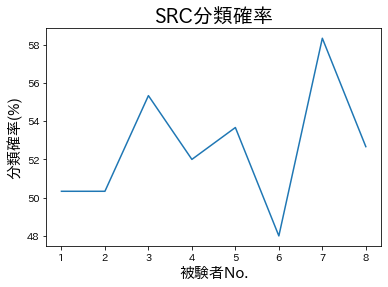

In [37]:
import matplotlib.pyplot as plt
import japanize_matplotlib
x = range(1,9)
y = p_average_250Hz[:,0]
plt.title("SRC分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.plot(x,y)
plt.savefig("2a_SRC_probability.pdf")
plt.show()
#テストデータを使った後付けなので使ったらダメ

In [18]:
probability = np.array([])
temp,temp1,temp2 = SRC_test("emotiv_data/feat_left_emotiv_K0.txt","emotiv_data/feat_right_emotiv_K0.txt","emotiv_data/feat_test_left_emotiv.txt","emotiv_data/feat_test_right_emotiv.txt")
temp_l = np.array([temp,temp1,temp2])
print(temp_l)
temp,temp1,temp2 = SRC_test("emotiv_data_2/feat_left_emotiv_20.txt","emotiv_data_2/feat_right_emotiv_20.txt","emotiv_data_2/feat_test_left_emotiv.txt","emotiv_data_2/feat_test_right_emotiv.txt")
temp_l = np.array([temp,temp1,temp2])
print(temp_l)
temp,temp1,temp2 = SRC_test("emotiv_data_3/feat_left_emotiv_20.txt","emotiv_data_3/feat_right_emotiv_20.txt","emotiv_data_3/feat_test_left_emotiv.txt","emotiv_data_3/feat_test_right_emotiv.txt")
temp_l = np.array([temp,temp1,temp2])
print(temp_l)

[ 50. 100.   0.]
[45. 82.  8.]
[ 50.   0. 100.]


In [18]:
#train=20,test=20で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_aa_20_K0.txt","feat_4a_1000Hz_20/feat_foot_aa_20_K0.txt","feat_4a_1000Hz_20/feat_test_right_aa_20.txt","feat_4a_1000Hz_20/feat_test_foot_aa_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_4a_1000Hz_20/feat_right_al_20_K0.txt","feat_4a_1000Hz_20/feat_foot_al_20_K0.txt","feat_4a_1000Hz_20/feat_test_right_al_20.txt","feat_4a_1000Hz_20/feat_test_foot_al_20.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability = probability.reshape([2, 3])
print(probability)


[[28.75  0.   57.5 ]
 [45.   67.5  22.5 ]]


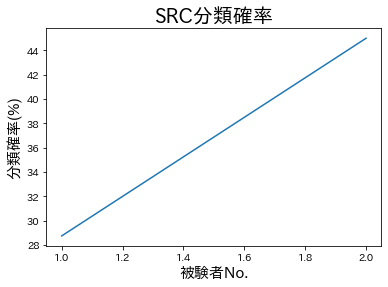

In [20]:
import matplotlib.pyplot as plt
import japanize_matplotlib
x = range(1,3)
y = probability[:,0]
plt.title("SRC分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.plot(x,y)
plt.savefig("4a_SRC_probability.pdf")
plt.show()

In [12]:
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_left_emotiv_2_K0.txt","feat_right_emotiv_2_K0.txt","feat_test_left_emotiv_2.txt","feat_test_right_emotiv_2.txt")
temp_l = np.array([temp,temp1,temp2])
print(temp_l)

OSError: feat_left_emotiv_2_K0.txt not found.